# Analysis of Motor Vehicle Collisions and Crash Trends

This dataset's focus on analyzing various aspects of motor vehicle collisions, such as trends, contributing factors, and impacts

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)
low_memory=False

In [42]:
def wrangle(filepath):
    #read csv file into dataframe
    df=pd.read_csv(filepath, low_memory=False)

    #drop columns and empty rows with NAN
    df.drop(columns="CONTRIBUTING FACTOR VEHICLE 3", inplace=True)
    df.drop(columns="CONTRIBUTING FACTOR VEHICLE 4",inplace=True)
    df.drop(columns="CONTRIBUTING FACTOR VEHICLE 5",inplace=True)
    df.drop(columns="VEHICLE TYPE CODE 3", inplace=True)
    df.drop(columns="VEHICLE TYPE CODE 4", inplace=True)
    df.drop(columns="VEHICLE TYPE CODE 5", inplace=True)
    df.drop(columns="OFF STREET NAME", inplace=True)
    df.dropna(inplace=True)
    
        #CHANGE TO DATETIME 
    df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
            #CHANGE THE DATA TYPE FROM STRINGS TO FLOAT 
    df["NUMBER OF CYCLIST INJURED"] = pd.to_numeric(df["NUMBER OF CYCLIST INJURED"], errors= 'coerce').astype(float)
    
    # Replace incomplete time values (e.g., "4:") with NaN
    df['CRASH TIME'] = df['CRASH TIME'].apply(lambda x: x if ':' in str(x) and len(str(x).split(':')) == 2 else None)
    
    # Drop rows with NaN in 'CRASH TIME' after the above replacement
    df.dropna(subset=['CRASH TIME'], inplace=True)
    
    # Convert to datetime format, then extract the hour
    df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce')
    df.dropna(subset=['CRASH TIME'], inplace=True)  # Drop any remaining invalid entries

        #CHANGE THE DATA TYPE FROM STRINGS TO FLOAT
    df["ZIP CODE"] = pd.to_numeric(df["ZIP CODE"], errors='coerce')

     #subset of number of injured and killed
    kill_person=df["NUMBER OF PERSONS KILLED"]>=0
    inj_person=df["NUMBER OF PERSONS INJURED"]>=0
    inj_pedes=df["NUMBER OF PEDESTRIANS INJURED"]>=0
    kill_pedes=df["NUMBER OF PEDESTRIANS KILLED"]>=0
    inj_cycl=df["NUMBER OF CYCLIST INJURED"]>=0
    kill_cycl=df["NUMBER OF CYCLIST KILLED"]>=0
    inj_motor=df["NUMBER OF MOTORIST INJURED"]>=0

    #JOIN THE SUBSET TOGETHER
    df=df[kill_person & inj_person & inj_pedes & kill_pedes & inj_cycl & kill_cycl & inj_motor]

    return df

In [44]:
df=wrangle("Motor_Vehicle_Collisions_-_Crashes.csv")
print("df shape", df.shape)
df.head()

df shape (537959, 22)


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
9,2021-12-14,1900-01-01 14:58:00,MANHATTAN,10017.0,40.751440,-73.973970,"(40.75144, -73.97397)",3 AVENUE,EAST 43 STREET,0.0,...,0.0,0.0,0.0,0.0,0.0,Passing Too Closely,Unspecified,4486519.0,Sedan,Station Wagon/Sport Utility Vehicle
11,2021-12-14,1900-01-01 16:50:00,QUEENS,11413.0,40.675884,-73.755770,"(40.675884, -73.75577)",SPRINGFIELD BOULEVARD,EAST GATE PLAZA,0.0,...,0.0,0.0,0.0,0.0,0.0,Turning Improperly,Unspecified,4487127.0,Sedan,Station Wagon/Sport Utility Vehicle
14,2021-12-14,1900-01-01 23:10:00,QUEENS,11434.0,40.666840,-73.789410,"(40.66684, -73.78941)",NORTH CONDUIT AVENUE,150 STREET,2.0,...,0.0,0.0,0.0,2.0,0.0,Reaction to Uninvolved Vehicle,Unspecified,4486635.0,Sedan,Sedan
18,2021-12-11,1900-01-01 19:43:00,BRONX,10463.0,40.872620,-73.904686,"(40.87262, -73.904686)",WEST KINGSBRIDGE ROAD,HEATH AVENUE,1.0,...,0.0,0.0,0.0,1.0,0.0,Unspecified,Unspecified,4487040.0,Station Wagon/Sport Utility Vehicle,Sedan
24,2021-12-13,1900-01-01 17:40:00,STATEN ISLAND,10301.0,40.631650,-74.087620,"(40.63165, -74.08762)",VICTORY BOULEVARD,WOODSTOCK AVENUE,1.0,...,0.0,0.0,0.0,1.0,0.0,Unspecified,Unspecified,4487001.0,Sedan,Sedan


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537959 entries, 9 to 1454018
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH DATE                     537959 non-null  datetime64[ns]
 1   CRASH TIME                     537959 non-null  datetime64[ns]
 2   BOROUGH                        537959 non-null  object        
 3   ZIP CODE                       537955 non-null  float64       
 4   LATITUDE                       537959 non-null  float64       
 5   LONGITUDE                      537959 non-null  float64       
 6   LOCATION                       537959 non-null  object        
 7   ON STREET NAME                 537959 non-null  object        
 8   CROSS STREET NAME              537959 non-null  object        
 9   NUMBER OF PERSONS INJURED      537959 non-null  float64       
 10  NUMBER OF PERSONS KILLED       537959 non-null  float64       
 11  NUMB

In [40]:
df.to_csv('Motor_Vehicle_Collisions_-_Crashes_clean.csv', index=False)

In [6]:
df.nunique()

CRASH DATE                         2914
CRASH TIME                         1440
BOROUGH                               5
ZIP CODE                            195
LATITUDE                          57439
LONGITUDE                         54375
LOCATION                          64689
ON STREET NAME                     9004
CROSS STREET NAME                 11567
NUMBER OF PERSONS INJURED            23
NUMBER OF PERSONS KILLED              6
NUMBER OF PEDESTRIANS INJURED         7
NUMBER OF PEDESTRIANS KILLED          4
NUMBER OF CYCLIST INJURED             4
NUMBER OF CYCLIST KILLED              3
NUMBER OF MOTORIST INJURED           24
NUMBER OF MOTORIST KILLED             4
CONTRIBUTING FACTOR VEHICLE 1        60
CONTRIBUTING FACTOR VEHICLE 2        60
COLLISION_ID                     537959
VEHICLE TYPE CODE 1                 639
VEHICLE TYPE CODE 2                 831
dtype: int64

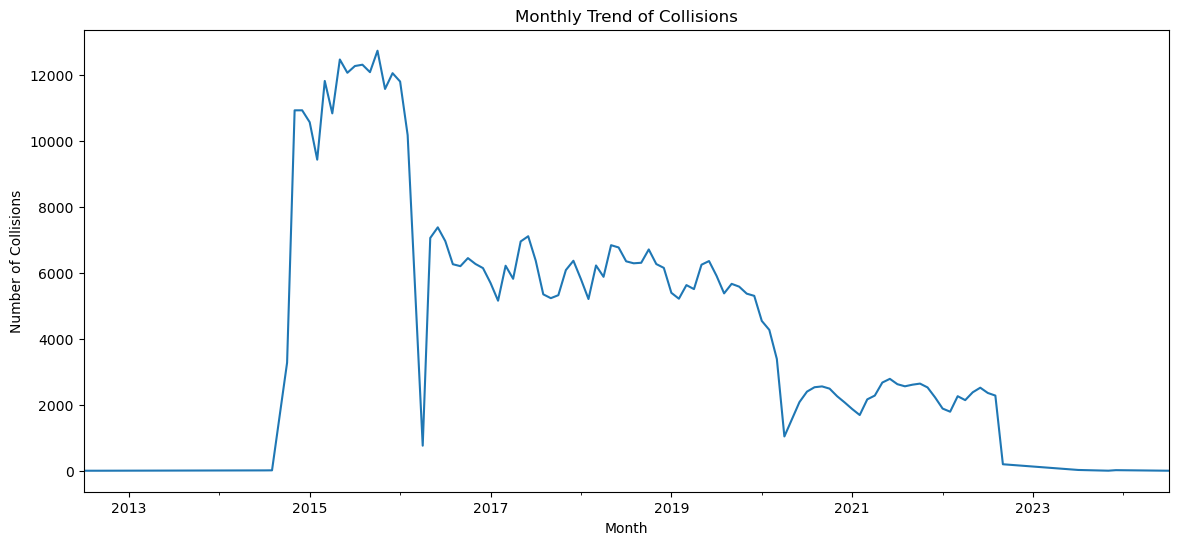

In [7]:
# Group by month and count collisions
df['Month'] = df['CRASH DATE'].dt.to_period('M')
monthly_collisions = df.groupby('Month').size()

# Plot the trend
plt.figure(figsize=(14, 6))
monthly_collisions.plot(kind='line')
plt.title("Monthly Trend of Collisions")
plt.xlabel("Month")
plt.ylabel("Number of Collisions")
plt.show()

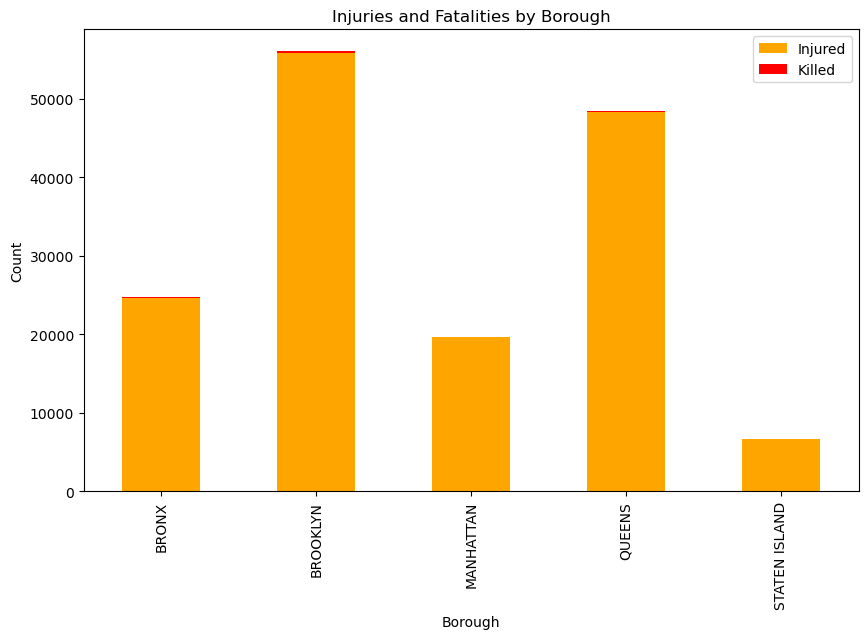

In [8]:
# Aggregate injuries and fatalities by borough
borough_data = df.groupby('BOROUGH')[['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']].sum()

# Plot injuries and fatalities by borough
borough_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['orange', 'red'])
plt.title("Injuries and Fatalities by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.legend(["Injured", "Killed"])
plt.show()

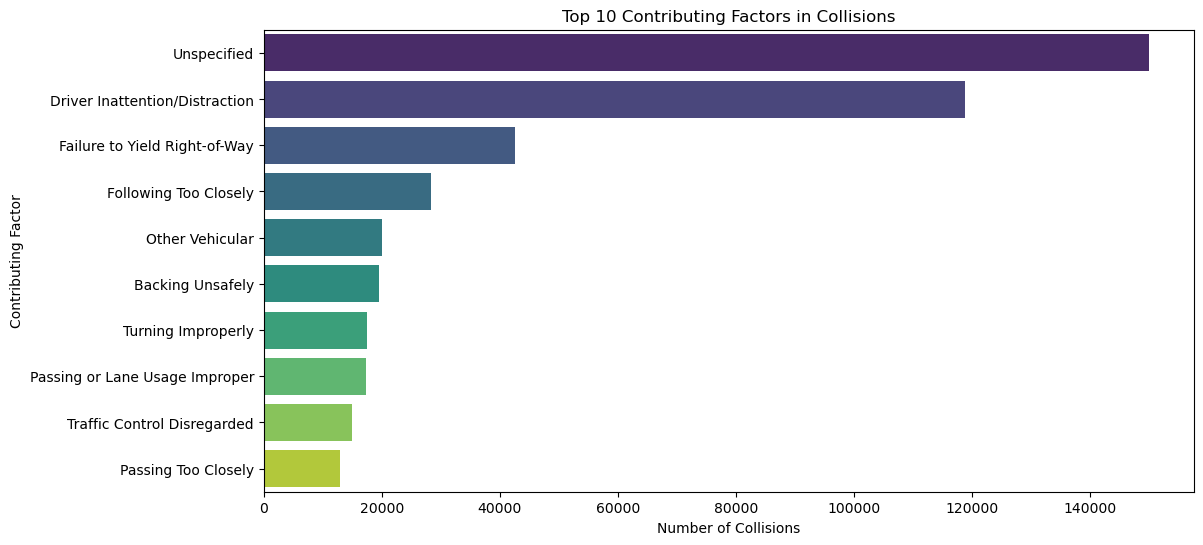

In [9]:
# Count each contributing factor
top_factors = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(10)

# Plot top contributing factors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_factors.values, y=top_factors.index, palette="viridis")
plt.title("Top 10 Contributing Factors in Collisions")
plt.xlabel("Number of Collisions")
plt.ylabel("Contributing Factor")
plt.show()

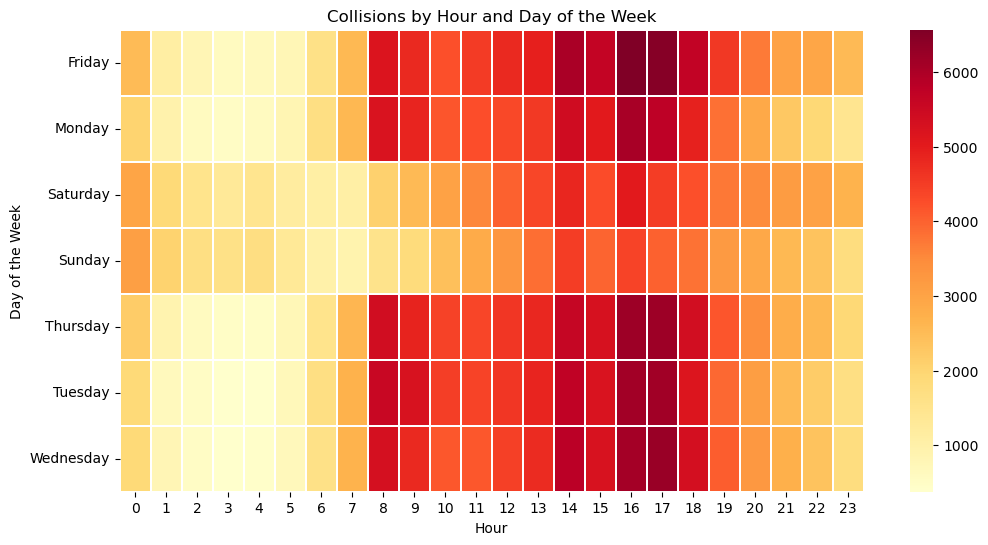

In [10]:
# Extract hour and weekday
df['Hour'] = df['CRASH TIME'].dt.hour
df['Weekday'] = df['CRASH DATE'].dt.day_name()

# Now create the heatmap
heatmap_data = df.pivot_table(index='Weekday', columns='Hour', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=0.1)
plt.title("Collisions by Hour and Day of the Week")
plt.xlabel("Hour")
plt.ylabel("Day of the Week")
plt.show()

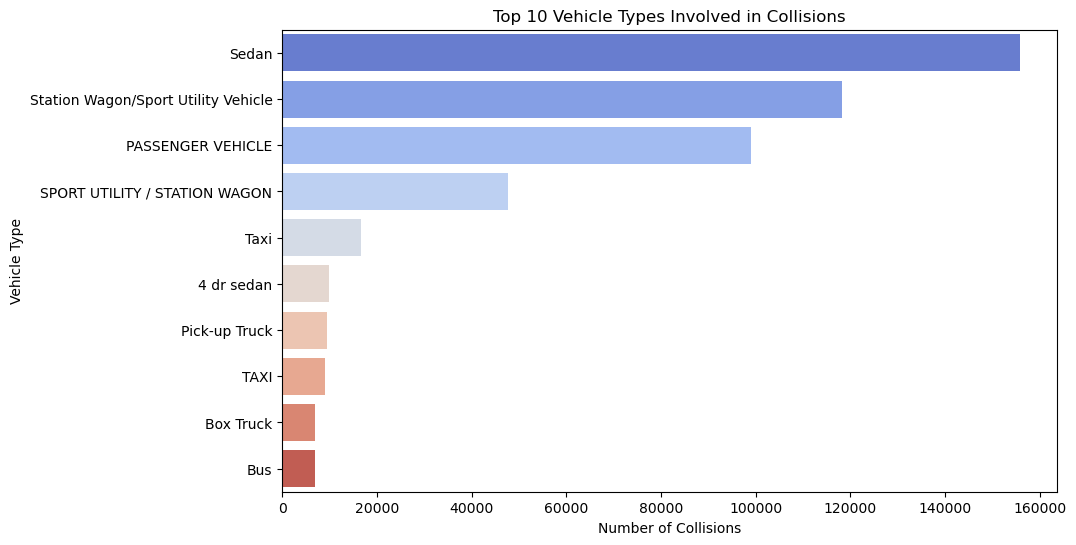

In [11]:
# Count each vehicle type
vehicle_counts = df['VEHICLE TYPE CODE 1'].value_counts().nlargest(10)

# Plot vehicle collision counts
plt.figure(figsize=(10, 6))
sns.barplot(x=vehicle_counts.values, y=vehicle_counts.index, palette="coolwarm")
plt.title("Top 10 Vehicle Types Involved in Collisions")
plt.xlabel("Number of Collisions")
plt.ylabel("Vehicle Type")
plt.show()

# Summary
### These visualizations can help identify trends and factors in motor vehicle collisions:

* Monthly trends reveal seasonal patterns.

* Injuries and fatalities by borough highlight areas with severe collisions.

* Contributing factors can guide safety improvements.

* Hourly and weekday heatmaps help pinpoint high-risk times.

* Vehicle type involvement shows the types most often involved in collisions.

* These visuals provide valuable insights into collision patterns, potentially aiding in improving road safety.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Aggregate monthly collision data
monthly_data = df.set_index('CRASH DATE').resample('M').size()

In [14]:
# Split data into train and test sets
train = monthly_data[:-12]  # Train on all but the last 12 months
test = monthly_data[-12:]   # Test on the last 12 months

# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))  # order may vary depending on data analysis
arima_result = model.fit()

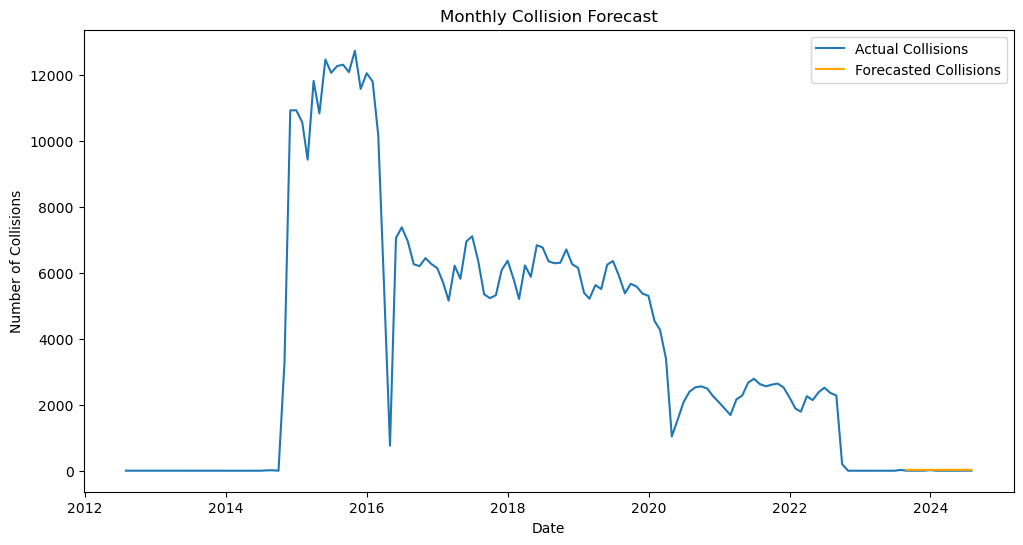

In [15]:
# Forecast for the next 12 months
forecast = arima_result.forecast(steps=12)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Actual Collisions')
plt.plot(forecast, label='Forecasted Collisions', color='orange')
plt.title('Monthly Collision Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

In [16]:
# Define the target variable (e.g., severe collision or not)
df['Severe_Collision'] = (df['NUMBER OF PERSONS KILLED'] > 0) | (df['NUMBER OF PERSONS INJURED'] > 1)

# Select feature columns (e.g., 'BOROUGH', 'CONTRIBUTING FACTOR', etc.)
features = df[['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2']]
features = pd.get_dummies(features, drop_first=True)

target = df['Severe_Collision']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions and evaluation
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.94      1.00      0.97    101524
        True       0.09      0.00      0.00      6068

    accuracy                           0.94    107592
   macro avg       0.52      0.50      0.49    107592
weighted avg       0.90      0.94      0.92    107592



# Summary
Predictive analysis on collision data can:

Forecast monthly collision counts to identify periods with higher risks.
Classify high-severity collisions based on contributing factors, location, and timing, helping prioritize safety interventions.
This analysis can guide road safety efforts by forecasting high-risk times or areas and understanding collision severity drivers.

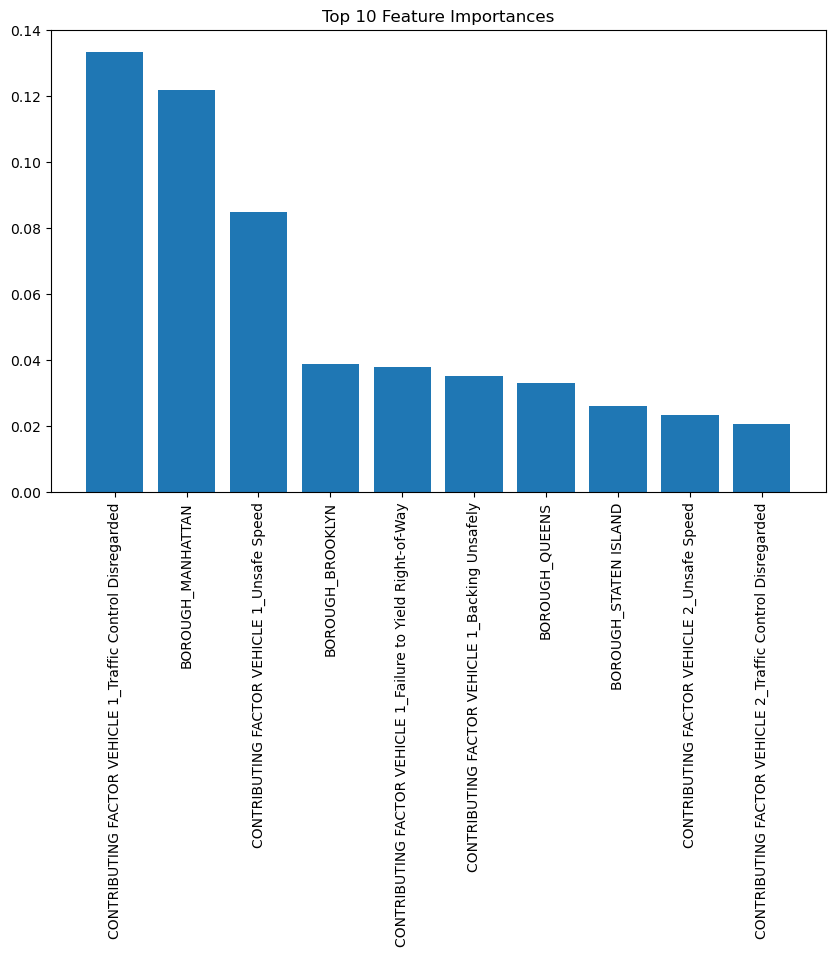

In [20]:
# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances
indices = np.argsort(feature_importances)[::-1]
top_features = 10  # Number of top features to display

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_features), feature_importances[indices][:top_features], align="center")
plt.xticks(range(top_features), [features.columns[i] for i in indices[:top_features]], rotation=90)
plt.show()